# Import All required Library

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Get all image file paths from the directory
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith('.jpg')]

        if not self.image_paths:
            print(f"Warning: No .jpg images found in {root_dir}. Please check the directory path and contents.")


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # Apply the transform if provided
        if self.transform:
            image = self.transform(image)

        return image

 # Load and Preprocess Celab Dataset

In [ ]:
import zipfile
import os

# Path to your ZIP file in Google Drive
zip_path = "/content/drive/MyDrive/img_align_celeba.zip"

# Folder where you want to extract the contents
extract_folder = "/content/drive/MyDrive/CelebADataset"

# Create the folder if it doesn't exist
os.makedirs(extract_folder, exist_ok=True)

# Check if the folder is already unzipped (check if it contains files)
if len(os.listdir(extract_folder)) == 0:
    print("Folder is empty. Unzipping now...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print("Unzipping completed. Files extracted to:", extract_folder)
else:
    print("Extraction skipped. Dataset already unzipped at:", extract_folder)


Extraction skipped. Dataset already unzipped at: /content/drive/MyDrive/CelebADataset


In [ ]:
# Define transformations (resize, crop, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize(64),  # Resize images to 64x64
    transforms.CenterCrop(64),  # Crop center to 64x64
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load CelebA dataset from the specified directory
dataset_path = '/content/drive/MyDrive/CelebADataset/img_align_celeba'
dataset = CelebADataset(root_dir=dataset_path, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Check how many images are loaded
print(f"Total number of images loaded: {len(dataset)}")

# Check the content of the directory to confirm the path
print(f"Contents of {dataset_path}: {os.listdir(dataset_path)[:10]}...") # Print first 10 items

Total number of images loaded: 81283
Contents of /content/drive/MyDrive/CelebADataset/img_align_celeba: ['080284.jpg', '080285.jpg', '080286.jpg', '080287.jpg', '080288.jpg', '080289.jpg', '080290.jpg', '080291.jpg', '080292.jpg', '080293.jpg']...


# Create Generator Model




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision
import numpy as np


# Generator and Discriminator classes (same as previously described)
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, img_channels * 64 * 64),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 64, 64)  # Reshape to image format
        return img



# Create Discriminator Model

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(img_channels * 64 * 64, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

# Define Loss and Optimizers

In [ ]:
# Loss function and optimizers
adversarial_loss = nn.BCELoss()
generator = Generator(z_dim=100)
discriminator = Discriminator()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

# Training Setup

In [ ]:
# Training loop
def train(generator, discriminator, dataloader, epochs=5):
    for epoch in range(epochs):
        for i, imgs in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batch_size = real_imgs.size(0)
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)
            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size, 100).to(device)).detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            # Train Generator
            optimizer_G.zero_grad()
            g_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size, 100).to(device))), valid)
            g_loss.backward()
            optimizer_G.step()
            if i % 50 == 0:
                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        # Optionally, save generated images at each epoch
        save_generated_images(generator, epoch, device)

[Epoch 0/10] [Batch 0/636] [D loss: 0.6957113742828369] [G loss: 0.7042314410209656]
[Epoch 0/10] [Batch 50/636] [D loss: 0.256030797958374] [G loss: 1.1044760942459106]
[Epoch 0/10] [Batch 100/636] [D loss: 0.16975516080856323] [G loss: 1.8719770908355713]
[Epoch 0/10] [Batch 150/636] [D loss: 0.25419938564300537] [G loss: 1.3282474279403687]
[Epoch 0/10] [Batch 200/636] [D loss: 0.24796687066555023] [G loss: 1.5926909446716309]
[Epoch 0/10] [Batch 250/636] [D loss: 0.043021298944950104] [G loss: 3.260836124420166]
[Epoch 0/10] [Batch 300/636] [D loss: 0.02681221067905426] [G loss: 4.039179801940918]
[Epoch 0/10] [Batch 350/636] [D loss: 0.05050710588693619] [G loss: 3.913397789001465]
[Epoch 0/10] [Batch 400/636] [D loss: 0.0595591738820076] [G loss: 4.39186954498291]
[Epoch 0/10] [Batch 450/636] [D loss: 0.025460271164774895] [G loss: 4.1715312004089355]
[Epoch 0/10] [Batch 500/636] [D loss: 0.1246451884508133] [G loss: 4.369533538818359]
[Epoch 0/10] [Batch 550/636] [D loss: 0.2855

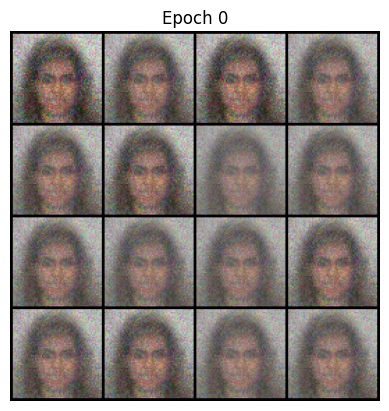

[Epoch 1/10] [Batch 0/636] [D loss: 0.947226881980896] [G loss: 9.458395004272461]
[Epoch 1/10] [Batch 50/636] [D loss: 0.01066671684384346] [G loss: 5.104419231414795]
[Epoch 1/10] [Batch 100/636] [D loss: 0.060397546738386154] [G loss: 3.6148500442504883]
[Epoch 1/10] [Batch 150/636] [D loss: 0.012666566297411919] [G loss: 5.137705326080322]
[Epoch 1/10] [Batch 200/636] [D loss: 0.05810917168855667] [G loss: 5.044638156890869]
[Epoch 1/10] [Batch 250/636] [D loss: 0.03626175969839096] [G loss: 4.874212265014648]
[Epoch 1/10] [Batch 300/636] [D loss: 0.5726271271705627] [G loss: 2.0510833263397217]
[Epoch 1/10] [Batch 350/636] [D loss: 0.0811782032251358] [G loss: 4.061634540557861]
[Epoch 1/10] [Batch 400/636] [D loss: 0.11268559098243713] [G loss: 5.502922058105469]
[Epoch 1/10] [Batch 450/636] [D loss: 0.05982566252350807] [G loss: 4.133961200714111]
[Epoch 1/10] [Batch 500/636] [D loss: 0.6582896113395691] [G loss: 24.11972999572754]
[Epoch 1/10] [Batch 550/636] [D loss: 0.1167850

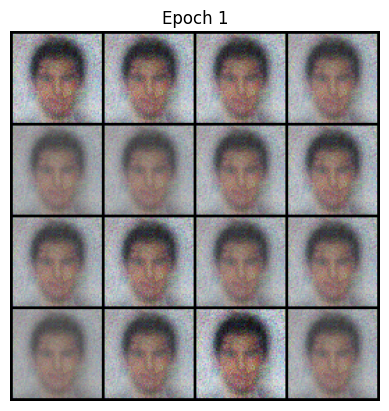

[Epoch 2/10] [Batch 0/636] [D loss: 1.7550100088119507] [G loss: 8.172967910766602]
[Epoch 2/10] [Batch 50/636] [D loss: 0.0272165909409523] [G loss: 3.0799524784088135]
[Epoch 2/10] [Batch 100/636] [D loss: 0.03721538931131363] [G loss: 4.74955940246582]
[Epoch 2/10] [Batch 150/636] [D loss: 0.009171223267912865] [G loss: 6.522777080535889]
[Epoch 2/10] [Batch 200/636] [D loss: 0.12180760502815247] [G loss: 4.459931373596191]
[Epoch 2/10] [Batch 250/636] [D loss: 0.19721733033657074] [G loss: 4.89735221862793]
[Epoch 2/10] [Batch 300/636] [D loss: 0.020657328888773918] [G loss: 5.2158026695251465]
[Epoch 2/10] [Batch 350/636] [D loss: 0.33421778678894043] [G loss: 5.478997230529785]
[Epoch 2/10] [Batch 400/636] [D loss: 0.23153045773506165] [G loss: 4.599612712860107]
[Epoch 2/10] [Batch 450/636] [D loss: 0.08048001676797867] [G loss: 3.571711778640747]
[Epoch 2/10] [Batch 500/636] [D loss: 0.057588186115026474] [G loss: 6.6290411949157715]
[Epoch 2/10] [Batch 550/636] [D loss: 0.1271

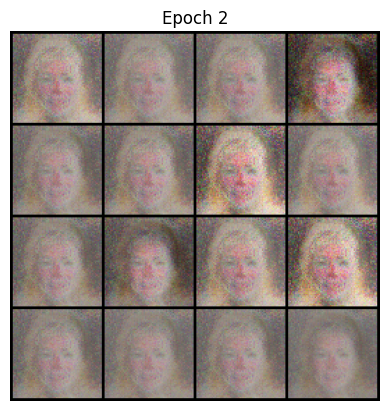

[Epoch 3/10] [Batch 0/636] [D loss: 0.04083283618092537] [G loss: 4.868674278259277]
[Epoch 3/10] [Batch 50/636] [D loss: 0.08260831981897354] [G loss: 4.163033485412598]
[Epoch 3/10] [Batch 100/636] [D loss: 0.07107703387737274] [G loss: 4.992475986480713]
[Epoch 3/10] [Batch 150/636] [D loss: 0.11485682427883148] [G loss: 3.622203826904297]
[Epoch 3/10] [Batch 200/636] [D loss: 0.13394823670387268] [G loss: 4.812056064605713]
[Epoch 3/10] [Batch 250/636] [D loss: 0.06219753250479698] [G loss: 4.695998191833496]
[Epoch 3/10] [Batch 300/636] [D loss: 0.027172092348337173] [G loss: 4.611902236938477]
[Epoch 3/10] [Batch 350/636] [D loss: 0.044357746839523315] [G loss: 6.597736835479736]
[Epoch 3/10] [Batch 400/636] [D loss: 0.03297605365514755] [G loss: 4.30188512802124]
[Epoch 3/10] [Batch 450/636] [D loss: 0.06235412508249283] [G loss: 3.7649409770965576]
[Epoch 3/10] [Batch 500/636] [D loss: 0.08728057146072388] [G loss: 4.610821723937988]
[Epoch 3/10] [Batch 550/636] [D loss: 0.0354

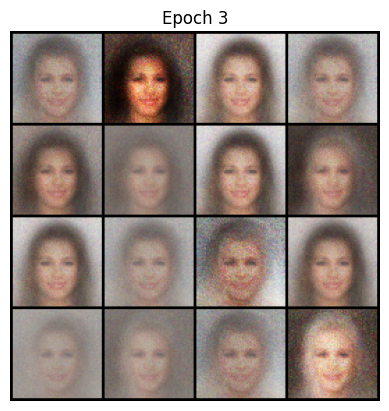

[Epoch 4/10] [Batch 0/636] [D loss: 0.03661860525608063] [G loss: 4.949324131011963]
[Epoch 4/10] [Batch 50/636] [D loss: 0.09133997559547424] [G loss: 5.273040771484375]
[Epoch 4/10] [Batch 100/636] [D loss: 0.09112811088562012] [G loss: 4.216762542724609]
[Epoch 4/10] [Batch 150/636] [D loss: 0.07989761233329773] [G loss: 4.755736827850342]
[Epoch 4/10] [Batch 200/636] [D loss: 0.06221335381269455] [G loss: 4.094189643859863]
[Epoch 4/10] [Batch 250/636] [D loss: 0.3009268045425415] [G loss: 3.4950051307678223]
[Epoch 4/10] [Batch 300/636] [D loss: 0.1658163070678711] [G loss: 4.063597202301025]
[Epoch 4/10] [Batch 350/636] [D loss: 0.16308894753456116] [G loss: 3.47074556350708]
[Epoch 4/10] [Batch 400/636] [D loss: 0.22479575872421265] [G loss: 4.852524757385254]
[Epoch 4/10] [Batch 450/636] [D loss: 0.25032559037208557] [G loss: 3.1268277168273926]
[Epoch 4/10] [Batch 500/636] [D loss: 0.188274085521698] [G loss: 5.346378803253174]
[Epoch 4/10] [Batch 550/636] [D loss: 0.183618381

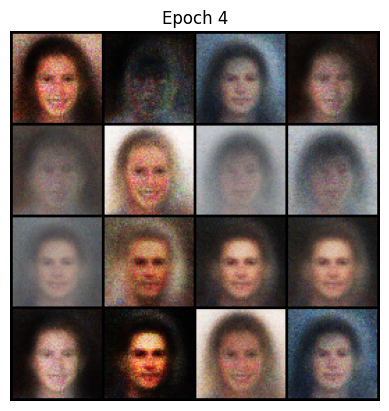

[Epoch 5/10] [Batch 0/636] [D loss: 0.21648406982421875] [G loss: 4.241860389709473]
[Epoch 5/10] [Batch 50/636] [D loss: 0.26605424284935] [G loss: 2.7748234272003174]
[Epoch 5/10] [Batch 100/636] [D loss: 0.1935480684041977] [G loss: 2.4600353240966797]
[Epoch 5/10] [Batch 150/636] [D loss: 0.15079382061958313] [G loss: 3.624910354614258]
[Epoch 5/10] [Batch 200/636] [D loss: 0.20809191465377808] [G loss: 4.024157524108887]
[Epoch 5/10] [Batch 250/636] [D loss: 0.28630393743515015] [G loss: 3.763331174850464]
[Epoch 5/10] [Batch 300/636] [D loss: 0.19119727611541748] [G loss: 3.5480494499206543]
[Epoch 5/10] [Batch 350/636] [D loss: 0.30303505063056946] [G loss: 4.506690979003906]
[Epoch 5/10] [Batch 400/636] [D loss: 0.2592005133628845] [G loss: 4.262629508972168]
[Epoch 5/10] [Batch 450/636] [D loss: 0.22237130999565125] [G loss: 3.207622766494751]
[Epoch 5/10] [Batch 500/636] [D loss: 0.22057797014713287] [G loss: 2.5860209465026855]
[Epoch 5/10] [Batch 550/636] [D loss: 0.1546520

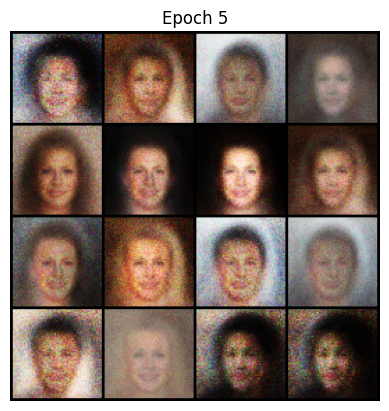

[Epoch 6/10] [Batch 0/636] [D loss: 0.9337978363037109] [G loss: 2.058234214782715]
[Epoch 6/10] [Batch 50/636] [D loss: 0.31235575675964355] [G loss: 3.7865004539489746]
[Epoch 6/10] [Batch 100/636] [D loss: 0.33806082606315613] [G loss: 4.233282089233398]
[Epoch 6/10] [Batch 150/636] [D loss: 0.3280279040336609] [G loss: 2.6764748096466064]
[Epoch 6/10] [Batch 200/636] [D loss: 0.34801024198532104] [G loss: 2.5500853061676025]
[Epoch 6/10] [Batch 250/636] [D loss: 0.7695786356925964] [G loss: 5.140857696533203]
[Epoch 6/10] [Batch 300/636] [D loss: 0.19904254376888275] [G loss: 3.413996696472168]
[Epoch 6/10] [Batch 350/636] [D loss: 0.20365512371063232] [G loss: 3.6602981090545654]
[Epoch 6/10] [Batch 400/636] [D loss: 0.3103892207145691] [G loss: 2.677203416824341]
[Epoch 6/10] [Batch 450/636] [D loss: 0.4598652422428131] [G loss: 4.537256240844727]
[Epoch 6/10] [Batch 500/636] [D loss: 0.3792875409126282] [G loss: 3.1896111965179443]
[Epoch 6/10] [Batch 550/636] [D loss: 0.2750331

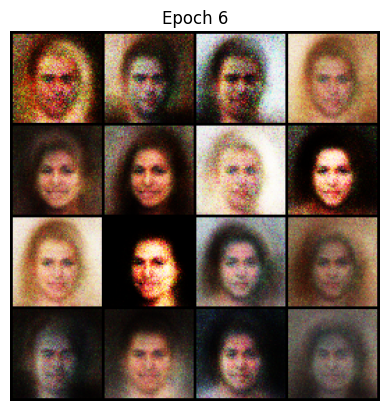

[Epoch 7/10] [Batch 0/636] [D loss: 0.5594882369041443] [G loss: 2.3852598667144775]
[Epoch 7/10] [Batch 50/636] [D loss: 0.35965174436569214] [G loss: 2.841656446456909]
[Epoch 7/10] [Batch 100/636] [D loss: 0.3807428777217865] [G loss: 2.3085579872131348]
[Epoch 7/10] [Batch 150/636] [D loss: 0.38477736711502075] [G loss: 2.2403621673583984]
[Epoch 7/10] [Batch 200/636] [D loss: 0.35038918256759644] [G loss: 2.267113208770752]
[Epoch 7/10] [Batch 250/636] [D loss: 0.38326743245124817] [G loss: 2.8551416397094727]
[Epoch 7/10] [Batch 300/636] [D loss: 0.4798603355884552] [G loss: 1.784525752067566]
[Epoch 7/10] [Batch 350/636] [D loss: 0.37381917238235474] [G loss: 2.746448516845703]
[Epoch 7/10] [Batch 400/636] [D loss: 0.4201311469078064] [G loss: 3.2733054161071777]
[Epoch 7/10] [Batch 450/636] [D loss: 0.36400747299194336] [G loss: 2.196723699569702]
[Epoch 7/10] [Batch 500/636] [D loss: 0.33067822456359863] [G loss: 2.029505968093872]
[Epoch 7/10] [Batch 550/636] [D loss: 0.29909

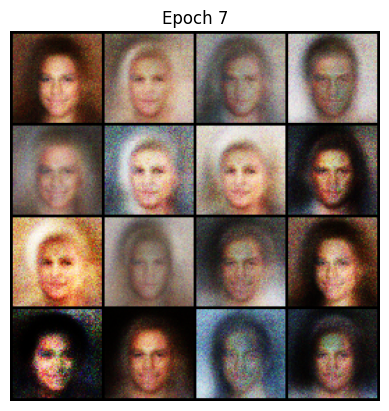

[Epoch 8/10] [Batch 0/636] [D loss: 0.5298594236373901] [G loss: 2.578824520111084]
[Epoch 8/10] [Batch 50/636] [D loss: 0.28681856393814087] [G loss: 2.095393180847168]
[Epoch 8/10] [Batch 100/636] [D loss: 0.4300413727760315] [G loss: 2.1039960384368896]
[Epoch 8/10] [Batch 150/636] [D loss: 0.47703343629837036] [G loss: 3.293519973754883]
[Epoch 8/10] [Batch 200/636] [D loss: 0.4434482753276825] [G loss: 1.8975627422332764]
[Epoch 8/10] [Batch 250/636] [D loss: 0.320783793926239] [G loss: 3.361121654510498]
[Epoch 8/10] [Batch 300/636] [D loss: 0.5469875931739807] [G loss: 2.8070201873779297]
[Epoch 8/10] [Batch 350/636] [D loss: 0.3470277190208435] [G loss: 2.6377110481262207]
[Epoch 8/10] [Batch 400/636] [D loss: 0.4704667329788208] [G loss: 1.8078522682189941]
[Epoch 8/10] [Batch 450/636] [D loss: 0.4552815556526184] [G loss: 1.9053324460983276]
[Epoch 8/10] [Batch 500/636] [D loss: 0.3285745680332184] [G loss: 2.459408760070801]
[Epoch 8/10] [Batch 550/636] [D loss: 0.4783110320

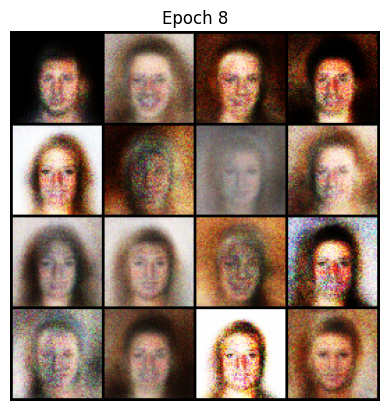

[Epoch 9/10] [Batch 0/636] [D loss: 0.7270694971084595] [G loss: 2.526362657546997]
[Epoch 9/10] [Batch 50/636] [D loss: 0.5458563566207886] [G loss: 2.973414421081543]
[Epoch 9/10] [Batch 100/636] [D loss: 0.4424576759338379] [G loss: 2.842729091644287]
[Epoch 9/10] [Batch 150/636] [D loss: 0.31982743740081787] [G loss: 2.2480928897857666]
[Epoch 9/10] [Batch 200/636] [D loss: 0.49005135893821716] [G loss: 1.7651562690734863]
[Epoch 9/10] [Batch 250/636] [D loss: 0.4841689467430115] [G loss: 2.408493995666504]
[Epoch 9/10] [Batch 300/636] [D loss: 0.4150277078151703] [G loss: 1.9274358749389648]
[Epoch 9/10] [Batch 350/636] [D loss: 0.5095118880271912] [G loss: 2.012681484222412]
[Epoch 9/10] [Batch 400/636] [D loss: 0.4221445322036743] [G loss: 2.5505309104919434]
[Epoch 9/10] [Batch 450/636] [D loss: 0.33489274978637695] [G loss: 2.1529901027679443]
[Epoch 9/10] [Batch 500/636] [D loss: 0.37016475200653076] [G loss: 2.0579769611358643]
[Epoch 9/10] [Batch 550/636] [D loss: 0.4179225

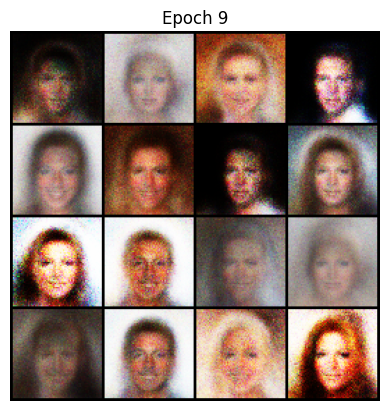

In [ ]:
def save_generated_images(generator, epoch, device, num_images=16):
    z = torch.randn(num_images, 100).to(device)
    generated_imgs = generator(z).detach().cpu()
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f"Epoch {epoch}")
    plt.axis('off')
    plt.show()

# Start training
train(generator, discriminator, dataloader, epochs=10)